# Model 1: Raw convolutional model

This model utilizes the functional Keras API to produce a mixed convolutional model.

In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Average, Concatenate, Conv2D, Dense, Flatten, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
meta = pd.read_csv('../processed_data/train.csv', index_col=0)
meta.head()

,age_approx,Unknown,female,male,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity,target
0,45.0,0,0,1,1,0,0,0,0,0,0
1,45.0,0,1,0,0,0,0,0,0,1,0
2,50.0,0,1,0,0,1,0,0,0,0,0
3,45.0,0,1,0,1,0,0,0,0,0,0
4,55.0,0,1,0,0,0,0,0,0,1,0


### Metadata

In [3]:
y = meta['target'].values.reshape(-1,1)
X = meta.drop('target', axis=1)
meta_train, meta_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=867_5309)

In [4]:
meta_train = meta_train.astype('ushort')
meta_test = meta_test.astype('ushort')

In [5]:
meta_train.shape

(23188, 10)

In [6]:
y_train.shape

(23188, 1)

### Image data

In [7]:
PATH = '../processed_data/processed_train_img_array.pkl'
with open(PATH, 'rb') as file:
    img_array = pickle.load(file)
img_array = img_array.astype('ushort')
img_train, img_test, _1, _2 = train_test_split(img_array, y, test_size=0.3, stratify=y, random_state=867_5309) # Should split exactly the same as above

In [8]:
img_train.shape

(23188, 80, 120, 3)

In [9]:
img_test.shape

(9938, 80, 120, 3)

### Model

In [10]:
LEARNING_RATE = 0.01

# Define inputs
meta_inputs = Input(shape=(10,))
img_inputs = Input(shape=(80,120,3,))

# Model 1
meta_layer1 = Dense(16, activation='relu')(meta_inputs)

# Model 2
padding_layer = ZeroPadding2D(padding=(1,1))(img_inputs)
img_conv_layer1 = Conv2D(4, kernel_size=(3,3), padding='same', activation='relu')(padding_layer)
img_gap_layer = GlobalAveragePooling2D()(img_conv_layer1)
img_dense_layer = Dense(8, activation='relu')(img_gap_layer)

# Merge models
merged = Concatenate()([meta_layer1, img_dense_layer])
output_layer = Dense(1, activation='sigmoid')(merged)

# Define functional model
model = Model(inputs=[meta_inputs, img_inputs], outputs=output_layer)

# Compile model
auc = AUC(name = 'auc')
adam = Adam(learning_rate=LEARNING_RATE)
model.compile(adam, loss='binary_crossentropy', metrics=[auc])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 120, 3)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 82, 122, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 82, 122, 4)   112         zero_padding2d[0][0]             
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10)]         0                                            
______________________________________________________________________________________________

See `fchollet`'s discussion of class weights [here](https://keras.io/examples/structured_data/imbalanced_classification/).

In [11]:
weight_for_0 = 1.0 / ((len(y_train)-y_train.sum())/len(y_train))
weight_for_1 = 1.0 / (y_train.sum()/len(y_train))
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.0180892167193538, 1: 56.28155339805825}

In [12]:
epochs = 10
history = model.fit([meta_train, img_train], y_train, epochs=epochs, batch_size=500, validation_data=([meta_test, img_test], y_test), class_weight=class_weight)

Epoch 1/10
47/47 [==============================] - 5s 58ms/step - loss: 6.6666 - auc: 0.5496 - val_loss: 0.5839 - val_auc: 0.6099
Epoch 2/10
47/47 [==============================] - 2s 40ms/step - loss: 1.5845 - auc: 0.6331 - val_loss: 0.9511 - val_auc: 0.6239
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 1.3730 - auc: 0.6225 - val_loss: 0.6069 - val_auc: 0.6475
Epoch 4/10
47/47 [==============================] - 2s 40ms/step - loss: 1.2728 - auc: 0.6507 - val_loss: 1.0317 - val_auc: 0.6470
Epoch 5/10
47/47 [==============================] - 2s 40ms/step - loss: 1.3575 - auc: 0.6604 - val_loss: 0.7964 - val_auc: 0.6472
Epoch 6/10
47/47 [==============================] - 2s 40ms/step - loss: 1.2949 - auc: 0.6575 - val_loss: 0.9599 - val_auc: 0.6501
Epoch 7/10
47/47 [==============================] - 2s 40ms/step - loss: 1.2918 - auc: 0.6840 - val_loss: 0.5543 - val_auc: 0.6493
Epoch 8/10
47/47 [==============================] - 2s 40ms/step - loss: 1.2794 - a

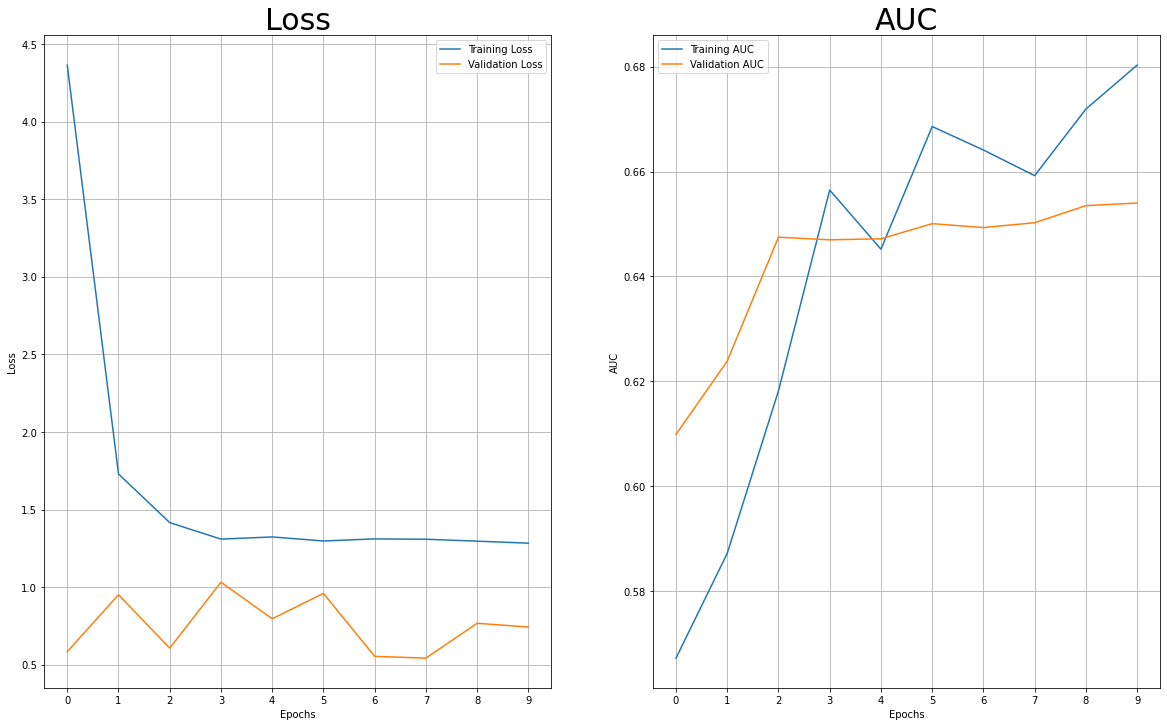

In [13]:
X = np.arange(0, epochs)

plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(X, history.history['loss'], label = 'Training Loss')
plt.plot(X, history.history['val_loss'], label = 'Validation Loss')
plt.grid(True)
plt.xticks(X)
plt.legend()
plt.title('Loss', fontsize=30)

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.plot(X, history.history['auc'], label = 'Training AUC')
plt.plot(X, history.history['val_auc'], label = 'Validation AUC')
plt.grid(True)
plt.xticks(X)
plt.legend()
_ = plt.title('AUC', fontsize=30)

In [14]:
y_pred = model.predict([meta_test, img_test])
y_pred = np.array([int(i) for i in y_pred > 0.5])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.51      0.67      9766
           1       0.02      0.68      0.05       172

    accuracy                           0.51      9938
   macro avg       0.51      0.60      0.36      9938
weighted avg       0.97      0.51      0.66      9938

